Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1085.51it/s, Materializing param=head.conv.weight]                                         


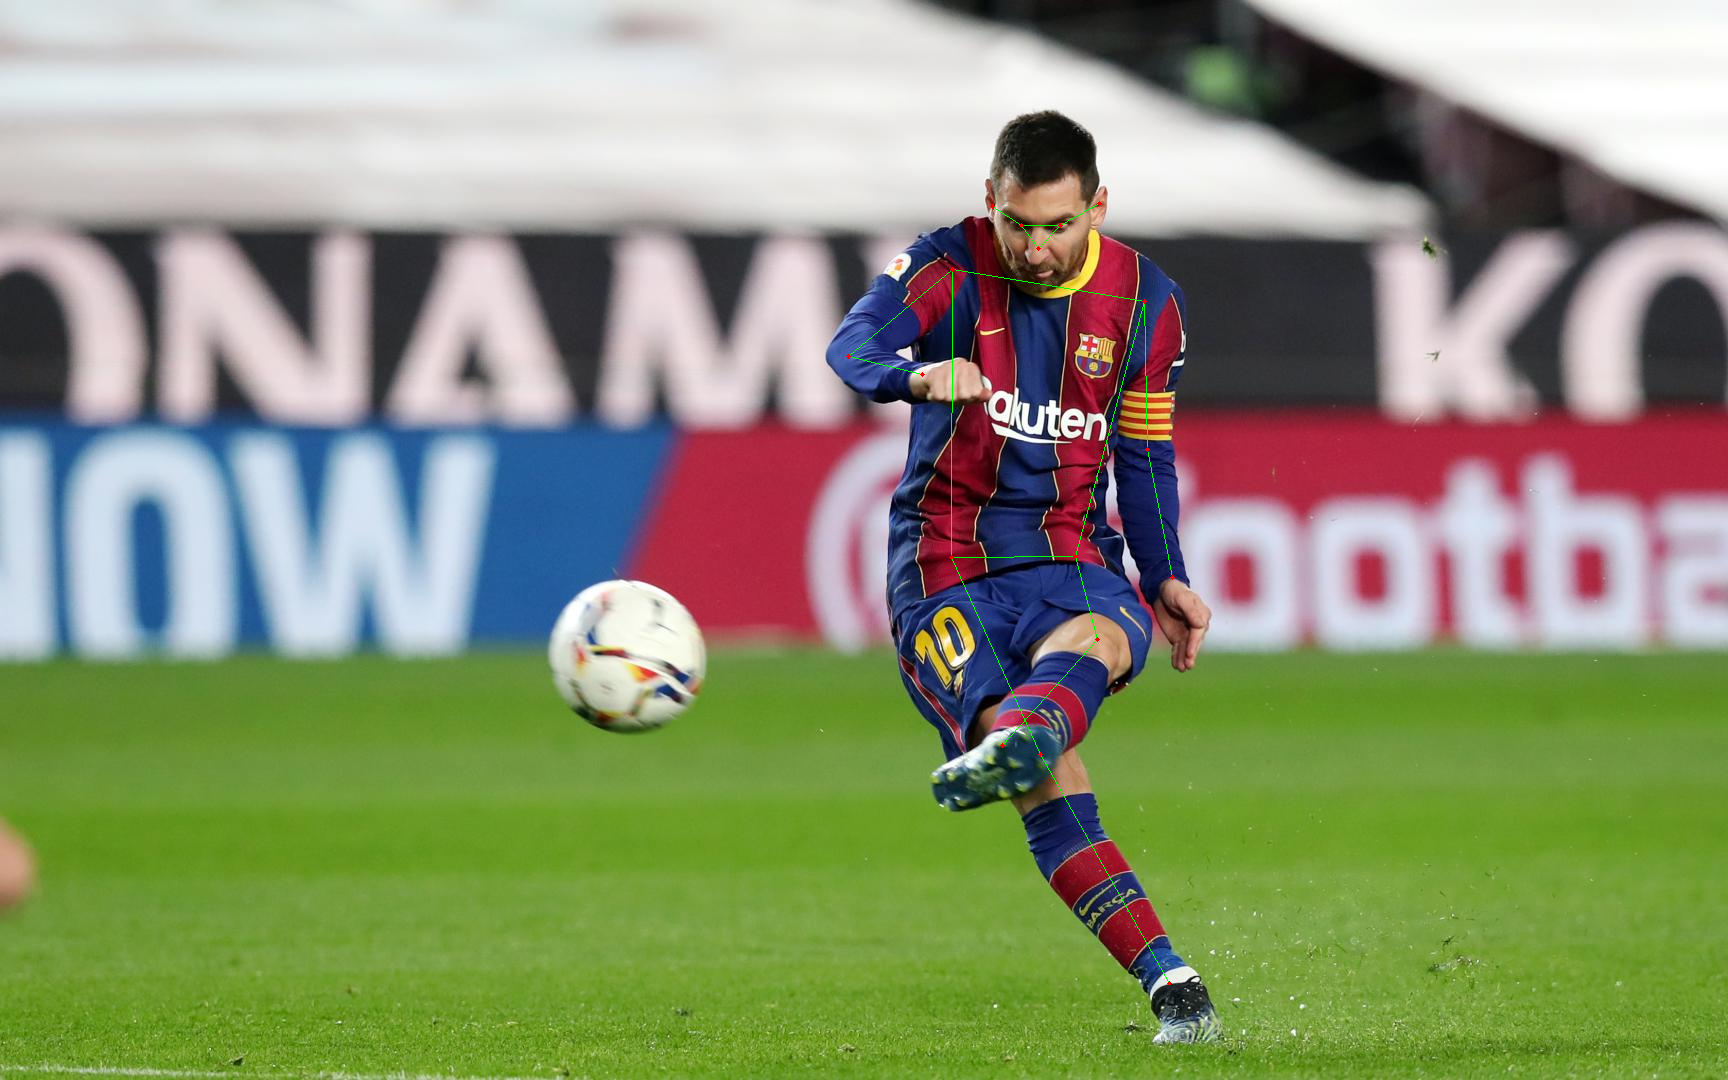

In [2]:
import torch
import requests
import numpy as np
import supervision as sv
from PIL import Image
from transformers import AutoProcessor, RTDetrForObjectDetection, VitPoseForPoseEstimation
from accelerate import Accelerator

device = Accelerator().device

url = "https://www.fcbarcelona.com/fcbarcelona/photo/2021/01/31/3c55a19f-dfc1-4451-885e-afd14e890a11/mini_2021-01-31-BARCELONA-ATHLETIC-BILBAOI-30.JPG"
image = Image.open(requests.get(url, stream=True).raw)

# Detect humans in the image
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", device_map=device)

inputs = person_image_processor(images=image, return_tensors="pt").to(person_model.device)

with torch.no_grad():
    outputs = person_model(**inputs)

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]

# Human label refers 0 index in COCO dataset
person_boxes = result["boxes"][result["labels"] == 0]
person_boxes = person_boxes.cpu().numpy()

# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]

# Detect keypoints for each person found
image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple")
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple", device_map=device)

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model(**inputs)

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes])
image_pose_result = pose_results[0]

xy = torch.stack([pose_result['keypoints'] for pose_result in image_pose_result]).cpu().numpy()
scores = torch.stack([pose_result['scores'] for pose_result in image_pose_result]).cpu().numpy()

key_points = sv.KeyPoints(
    xy=xy, confidence=scores
)

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.GREEN,
    thickness=1
)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.RED,
    radius=2
)
annotated_frame = edge_annotator.annotate(
    scene=image.copy(),
    key_points=key_points
)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points
)
annotated_frame